# Advances in Machine Learning with Big Data

### (part 1 of 2) 
### Trinity 2020 Weeks 1 - 4
### Dr Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [12, 4]

import sys, os

import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
UCI_LIB = os.path.join(REPO_DIR, 'lib')
sys.path.append(UCI_LIB)

import numpy as np  
import pandas as pd  

#  pull in scikit-learn libraries:
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold

import sbs_sklearn    # module where I've put some functions from the last class
from uci_retail_data import uci_files, stock_codes

import itertools      # today, we'll use this

Populating the interactive namespace from numpy and matplotlib


## 4. Regularization through predictor/feature selection (Lasso etc.)

## Contents Weeks 1-4:

1. Introducing this course's dataset

1. Being an econometrician _and_ a data scientist

1. Overfit and regularization

1. **Regularization through predictor/feature selection (Lasso etc.)**

1. Resampling methods, and model selection

1. Moving from linear regression to the perceptron

1. Moving from linear regression to the random forest (and similar)

Load data per previous classes ...

In [2]:
df = uci_files.standard_uci_data_access()

2020-04-19 19:24:12,097 INFO:Loading C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2020-04-19 19:24:14,912 INFO:Loaded C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


In [3]:
invalids = stock_codes.invalid_series(df)

In [4]:
invoices = stock_codes.invoice_df(df, invalid_series=invalids)

Next, we prepare the data for linear regression:

In [5]:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

predictors = ['log_n_codes', 'hour', 'month', 'words_per_item']

y = invoices.log_item_spend
X = invoices[predictors] 

Lets do 25 folds

In [6]:
n_folds = 25

### The danger of the OLS Polynomial Regression

(and how regularization fixes it)

We'll create polynomials of, say, orders up to 4:

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(4)
polynomial_X = pd.DataFrame(poly.fit_transform(X.values))
polynomial_X.columns = poly.get_feature_names(X.columns)
del polynomial_X['1']

Recall the options available from [`sbs_sklearn.train_n_test`](https://github.com/jeremy-large/ox-sbs-ml-bd/blob/master/lib/sbs_sklearn.py#L21)

In [8]:
sbs_sklearn.train_n_test?

Signature:
sbs_sklearn.train_n_test(
    X,
    y,
    n_folds,
    update_frequency=None,
    model=None,
    metric=None,
    train_on_minority=False,
)
Docstring:
@param X: a pandas DataFrame of features data of shape (A, B)
@param y: a pandas Series of target data, of length A
@param n_folds: the number of splits, or folds, of the data that we would like performed
@param update_frequency: after implementing this many folds, provide an update
@param model: by default LinearRegression(). Can also be set to another model with methods .fit() and .predict()
@param metric: by default metrics.r2_score. Can also be set to another metric
@param train_on_minority: if set to True, then reverse the roles of test and train
@return : a list of floats, each is the test R2 from a fold of the data
File:      c:\users\jerem\documents\work\oxford\sbs\mlbd\ox-sbs-ml-bd\lib\sbs_sklearn.py
Type:      function


As we know, training with Linear Regression is not great in test data

2020-04-19 19:26:49,171 INFO:In study 1/25, train on 824 points; then test on the other 19753: first few test points = [0 1 2 3 4] 


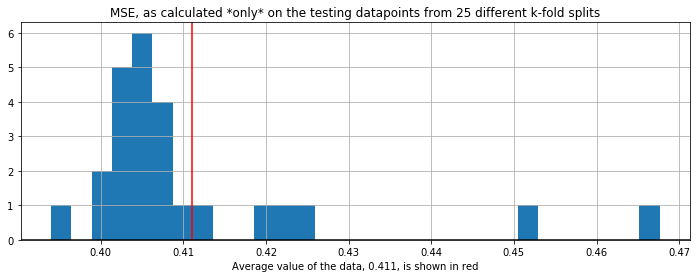

In [9]:
scores = sbs_sklearn.train_n_test(polynomial_X, y, n_folds, train_on_minority=True, 
                                  model=linear_model.LinearRegression() )  # << standard LinearRegression()
sbs_sklearn.plot_kfold_scores(scores)

... so lets move towards regularization, beginning with [scikit-learn's Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)


First we standardize the regressors:

**Exercise** : why?

In [10]:
poly_std_X = ((polynomial_X - polynomial_X.mean()) / polynomial_X.std())

Check this makes no difference to Linear Regression:

(is just a linear transform of the regressors)

2020-04-19 19:26:50,072 INFO:In study 1/25, train on 824 points; then test on the other 19753: first few test points = [0 1 2 3 4] 


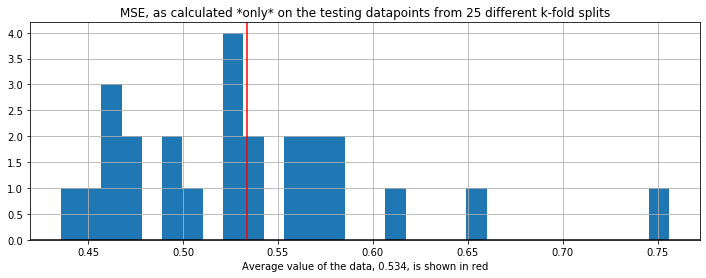

In [11]:
ols = linear_model.LinearRegression()   # << standard LinearRegression()
scores = sbs_sklearn.train_n_test(poly_std_X, y, n_folds, train_on_minority=True, model=ols)
sbs_sklearn.plot_kfold_scores(scores)

... but just look at these coefficients ...

In [12]:
def plot_coeffs(mod, mod_name, comment):
    plt.plot(mod.coef_, marker='o')
    plt.grid()
    plt.title(f"The betas of the {mod_name} - {comment}")
    plt.axhline(color='k')

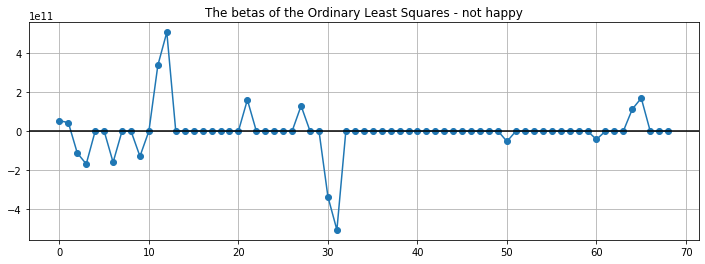

In [13]:
plot_coeffs(ols, 'Ordinary Least Squares', 'not happy')

Now swap in the [Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html):

(by the way, I picked alpha, $\alpha$, by a process of trial and error ...)

2020-04-19 19:26:51,071 INFO:In study 1/25, train on 824 points; then test on the other 19753: first few test points = [0 1 2 3 4] 


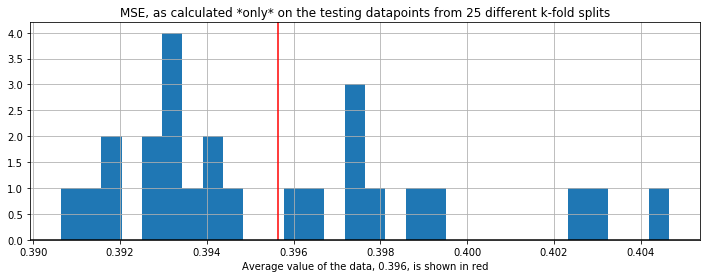

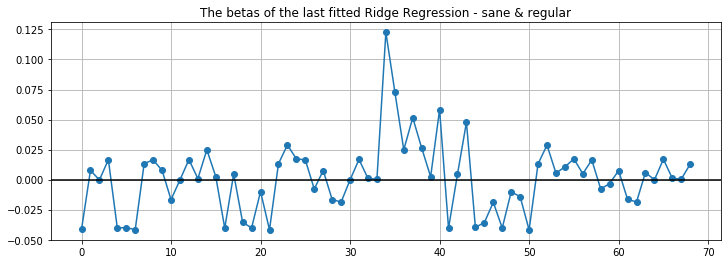

In [14]:
ridge = linear_model.Ridge(alpha=25) # << ridge regression deployed here
scores = sbs_sklearn.train_n_test(poly_std_X, y, n_folds, train_on_minority=True, model=ridge)
sbs_sklearn.plot_kfold_scores(scores)
plot_coeffs(ridge, 'last fitted Ridge Regression', 'sane & regular')

... easy to try the [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) instead:

(more trial-and-error in picking alpha, $\alpha$, bearing mind it is now scaled differently to [before](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)  )

2020-04-19 19:26:52,122 INFO:In study 1/25, train on 824 points; then test on the other 19753: first few test points = [0 1 2 3 4] 


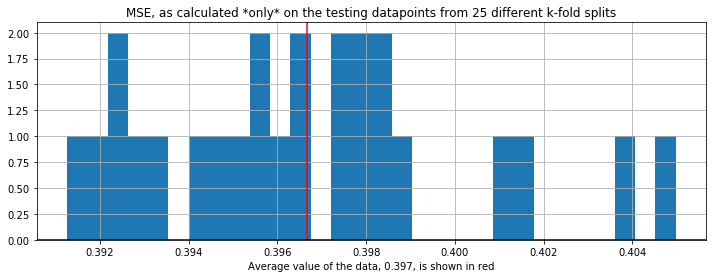

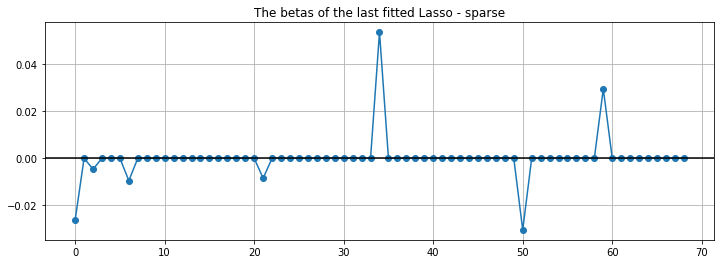

In [15]:
lasso = linear_model.Lasso(alpha=25 / (len(y) / n_folds) / 2) # << Lasso here

scores = sbs_sklearn.train_n_test(poly_std_X, y, n_folds, train_on_minority=True, model=lasso)
sbs_sklearn.plot_kfold_scores(scores)
plot_coeffs(lasso, 'last fitted Lasso', 'sparse')

In [16]:
# so, which predictors did Lasso keep?
for f in poly_std_X.columns[np.abs(lasso.coef_) > 0.005]:
    print(f)

log_n_codes
log_n_codes month
log_n_codes month^2
log_n_codes^4
log_n_codes month^3
hour^2 words_per_item^2


Finally, lets look at [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html):

(more trial-and-error in picking alpha, $\alpha$)

2020-04-19 19:26:53,291 INFO:In study 1/25, train on 824 points; then test on the other 19753: first few test points = [0 1 2 3 4] 


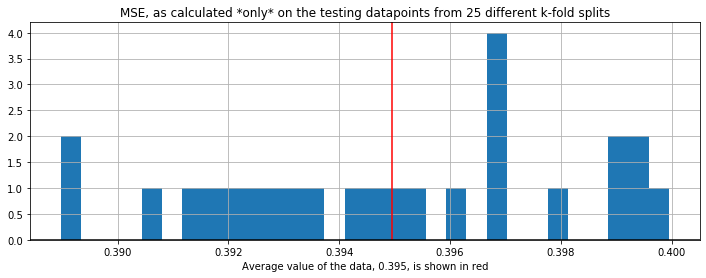

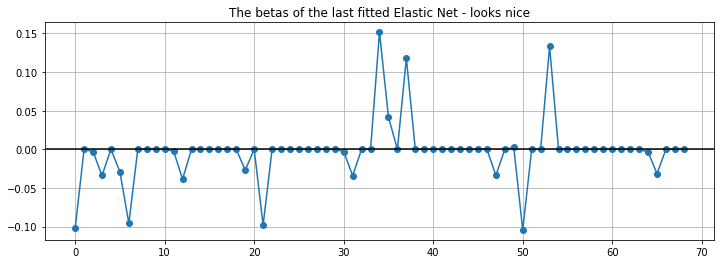

In [17]:
elastic = linear_model.ElasticNet( # << Elastic Net here
                                  alpha=25 / (len(y) / n_folds) / 2,   # alpha parameter
                                  l1_ratio=0.33                        # how to distribute the parameter between l1 and l2 norms
                                 )
scores = sbs_sklearn.train_n_test(poly_std_X, y, n_folds, train_on_minority=True, model=elastic)
sbs_sklearn.plot_kfold_scores(scores)
plot_coeffs(elastic, 'last fitted Elastic Net', 'looks nice')

In [18]:
# Ideally, of course, we'd be able to interpret the non-zero coefficients !?:
for i, c in enumerate(elastic.coef_):
    if np.abs(c) > 0.005:
        print(sign(c), '  ', poly_std_X.columns[i])

-1.0    log_n_codes
-1.0    words_per_item
-1.0    log_n_codes hour
-1.0    log_n_codes month
-1.0    month words_per_item
-1.0    log_n_codes hour month
-1.0    log_n_codes month^2
-1.0    month^2 words_per_item
1.0    log_n_codes^4
1.0    log_n_codes^3 hour
1.0    log_n_codes^3 words_per_item
-1.0    log_n_codes hour month^2
-1.0    log_n_codes month^3
1.0    log_n_codes words_per_item^3
-1.0    month^3 words_per_item


#### The picking of the tuning parameter ...

Recall, we have *parameters*, and we have *tuning parameters*: here, for example, `alpha` and `l1_ratio`